In [33]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import random as rn
import time
import joblib
from pathlib import Path
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from models import create_decoder,create_discriminator,create_encoder

In [34]:
#Constants
SEED = 42
EPOCHS = 200
GAMMA = 0.98
BASE_LR = 0.0001
MAX_LR = 0.005
H_DIM = [200,200]
Z_DIM = 50
BATCH_SIZE = 256

In [35]:
cur = Path.cwd()
db = pd.read_csv(os.path.join(cur,'../outputs/megasample_cleaned.csv'))
model_name = 'supervised_aae'
model_dir = cur / '../outputs/models' / model_name
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [36]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

# Data Preparation from DataFrame

In [37]:
cat_list = db.columns.tolist()
print(len(cat_list))

447


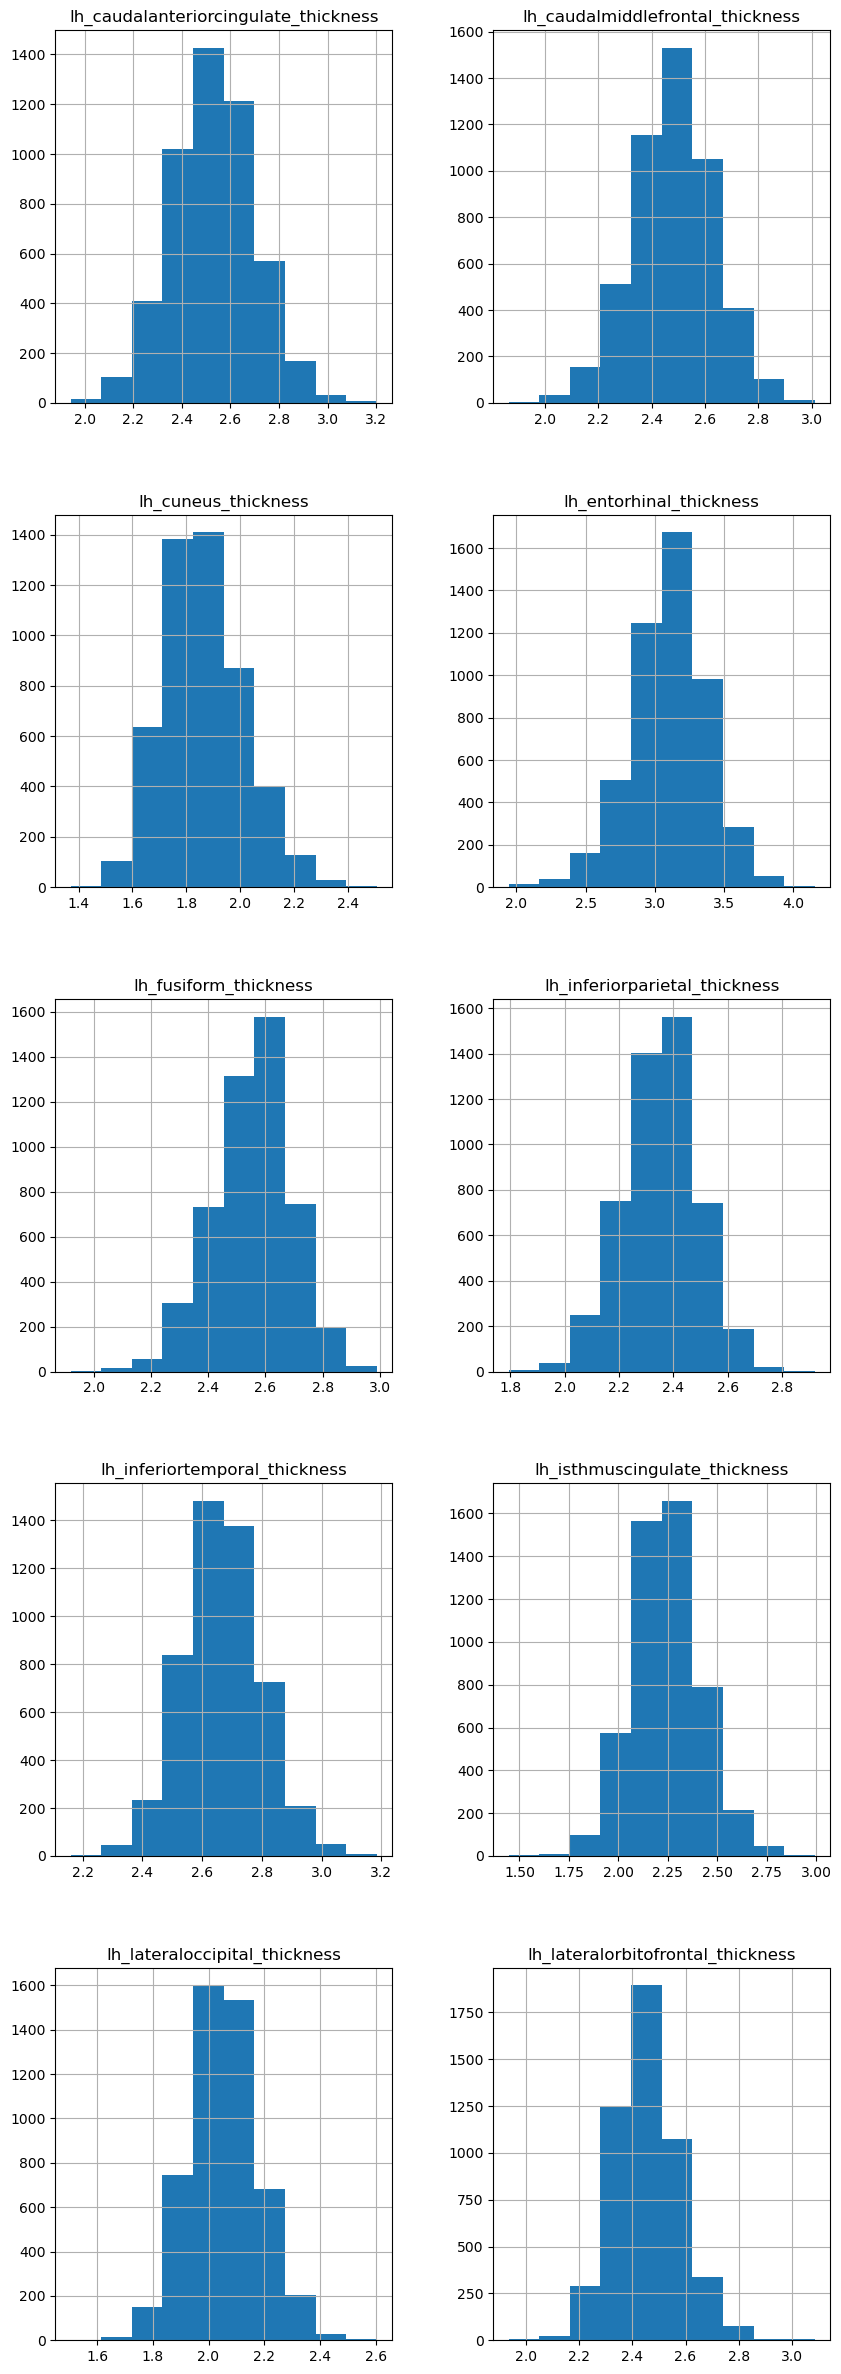

In [38]:
healthy_db = db.loc[db['dcode']==0]
x_data = healthy_db.drop(['age', 'sex', 'scanner', 'euler', 'BrainSegVolNotVent', 'euler_med', 'sample', 'dcode', 'timepoint'],axis=1,inplace=False)
x_data.iloc[:,:10].hist(figsize=(10,30),layout=(5,2));

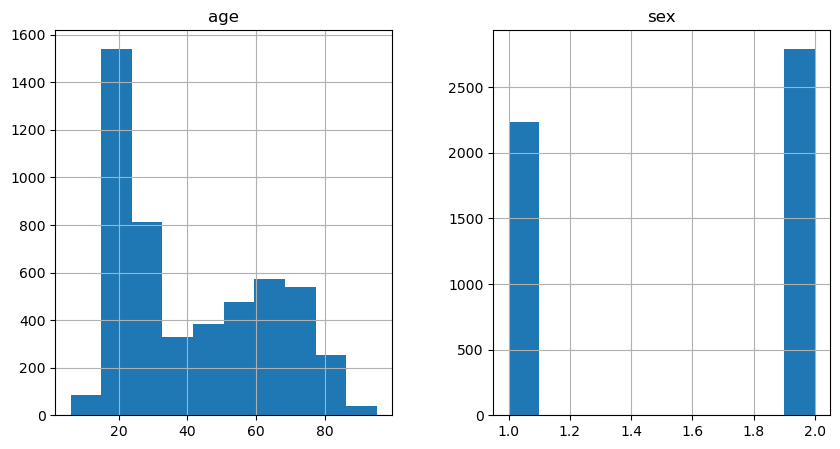

In [39]:
db.loc[:,['age','sex']].hist(figsize=(10,5),layout=(1,2));

## Data Normalization

In [40]:
total_brain_vol = db['BrainSegVolNotVent']
scaler = RobustScaler()
x_data_norm = scaler.fit_transform(x_data)

## Encoding Codependent Variables

In [41]:
enc_sex = OneHotEncoder(sparse=False)
one_hot_sex = enc_sex.fit_transform(healthy_db['sex'].values[:, np.newaxis].astype('float32'))

enc_age = OneHotEncoder(sparse=False)
age = healthy_db[['age']].round(0)
age.groupby('age',dropna=False)['age'].count()
one_hot_age = enc_age.fit_transform(age['age'].values[:, np.newaxis].astype('float32'))

y_data = np.concatenate((one_hot_age, one_hot_sex), axis=1).astype('float32')

In [42]:
# Create the dataset iterator
n_samples = x_data.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((x_data_norm, y_data))
train_dataset = train_dataset.shuffle(buffer_size=n_samples)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Model Creation

In [43]:
n_features = x_data_norm.shape[1]
n_labels = y_data.shape[1]

In [44]:
encoder = create_encoder(n_features, H_DIM, Z_DIM)
decoder = create_decoder(Z_DIM + n_labels, n_features, H_DIM)
discriminator = create_discriminator(Z_DIM, H_DIM)

## Defining Loss Functions

In [45]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()

def discriminator_loss(real_output, fake_output):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_fake + loss_real

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Defining Optimizers

In [46]:
step_size = 2 * np.ceil(n_samples / BATCH_SIZE)

ae_optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR)
dc_optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR)

# Define Training

In [47]:
@tf.function
def train_step(x_batch_tr, y_batch_tr):
    #Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(x_batch_tr, training=True)
        decoder_output = decoder(tf.concat([encoder_output,y_batch_tr],axis=1))

        #Autoencoder Loss
        ae_loss_tr = mse(x_batch_tr, decoder_output)

    ae_grads = ae_tape.gradient(ae_loss_tr, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([x_batch_tr.shape[0], Z_DIM], mean=0.0, stddev=1.0)
        encoder_output = encoder(x_batch_tr, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss_tr = discriminator_loss(dc_real, dc_fake)

        # Discriminator Acc
        dc_acc_tr = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                             tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss_tr, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(x_batch_tr, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss_tr = generator_loss(dc_fake)

    gen_grads = gen_tape.gradient(gen_loss_tr, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss_tr, dc_loss_tr, dc_acc_tr, gen_loss_tr

# Define Training Loop

In [48]:
scale_fn = lambda x: GAMMA ** x
global_step = 0
for epoch in range(EPOCHS):
    start = time.time()

    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()

    for _, (batch_x, batch_y) in enumerate(train_dataset):
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = BASE_LR + (MAX_LR - BASE_LR) * max(0, 1 - x_lr) * scale_fn(cycle)
        ae_optimizer.learning_rate = clr
        dc_optimizer.learning_rate = clr
        gen_optimizer.learning_rate = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x, batch_y)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)

    epoch_time = time.time() - start

    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (EPOCHS - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))

   0: TIME: 3.29 ETA: 657.45 AE_LOSS: 195.5649 DC_LOSS: 1.8512 DC_ACC: 0.5302 GEN_LOSS: 1.4043
   1: TIME: 0.26 ETA: 51.34 AE_LOSS: 312.5657 DC_LOSS: 9.3677 DC_ACC: 0.4066 GEN_LOSS: 10.6108
   2: TIME: 0.26 ETA: 50.80 AE_LOSS: 287.8542 DC_LOSS: 24.1944 DC_ACC: 0.3365 GEN_LOSS: 38.4646
   3: TIME: 0.26 ETA: 50.83 AE_LOSS: 437.5099 DC_LOSS: 6.7116 DC_ACC: 0.3402 GEN_LOSS: 34.1693
   4: TIME: 0.26 ETA: 50.96 AE_LOSS: 406.6249 DC_LOSS: 5.9438 DC_ACC: 0.3612 GEN_LOSS: 12.5648
   5: TIME: 0.25 ETA: 48.36 AE_LOSS: 664.0718 DC_LOSS: 3.1530 DC_ACC: 0.3833 GEN_LOSS: 11.2426
   6: TIME: 0.25 ETA: 48.50 AE_LOSS: 3508.5942 DC_LOSS: 1.3621 DC_ACC: 0.4020 GEN_LOSS: 7.9561
   7: TIME: 0.25 ETA: 48.83 AE_LOSS: 1152.8889 DC_LOSS: 1.1495 DC_ACC: 0.4224 GEN_LOSS: 4.1579
   8: TIME: 0.26 ETA: 50.79 AE_LOSS: 1862.1061 DC_LOSS: 1.1305 DC_ACC: 0.4400 GEN_LOSS: 3.9090
   9: TIME: 0.25 ETA: 47.75 AE_LOSS: 878.8644 DC_LOSS: 1.1739 DC_ACC: 0.4571 GEN_LOSS: 3.6538
  10: TIME: 0.27 ETA: 50.73 AE_LOSS: 364.4606 DC_L

# Save Results

In [49]:
encoder.save(model_dir / 'encoder.h5')
decoder.save(model_dir / 'decoder.h5')
discriminator.save(model_dir / 'discriminator.h5')

In [50]:
# Save scaler
joblib.dump(scaler, model_dir / 'scaler.joblib')

joblib.dump(enc_age, model_dir / 'age_encoder.joblib')
joblib.dump(enc_sex, model_dir / 'sex_encoder.joblib')

['C:\\Users\\alexg\\Documents\\GitHub\\Cortical-Thickness\\notebooks\\..\\outputs\\models\\supervised_aae\\sex_encoder.joblib']